In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from astropy.io import ascii
import os



import sys 
sys.path.append('..')
from functions import *
# from colormaps import new_colors
cmap = plt.get_cmap('tab10')
new_colors = cmap(range(10))

3.0rc2


In [222]:
UM_catalog_location = '/Users/fardila/Documents/Data/dwarf_lensing/UM/'

In [3]:
#takes several minutes to read in
UM_catalog = ascii.read(UM_catalog_location+'sfr_catalog_0.782092.txt')

In [4]:
UM_catalog

ID,DescID,UPID,Flags,Uparent_Dist,X,Y,Z,VX,VY,VZ,M,V,MP,VMP,R,Rank1,Rank2,RA,RARank,SM,ICL,SFR,obs_SM,obs_SFR,SSFR,SM/HM,obs_UV
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2402494409,14114279,-1,2,2.0,15.11237,23.927719,39.993809,-101.650002,271.350006,-501.309998,98690000000000.0,682.359985,98690000000000.0,682.359985,898.609985,-0.191796,-0.944612,0.193902,0.006995,624200000000.0,185500000000.0,1.416,422900000000.0,0.8877,2.099e-12,0.006324,-18.478
117000000134642248,14114292,2402494409,8,0.280267,15.139074,23.706131,40.110489,3.06712,126.532379,-455.335754,1126000000.0,107.72628,40340000000.0,111.809998,20.232403,-0.168347,1.096783,0.355356,0.004981,5254000000.0,0.0,1.234,2799000000.0,0.703,2.512e-10,0.1303,-18.264
112000000220447759,14114305,2402494409,8,0.176275,15.21314,23.978075,39.88245,-390.766541,-116.732033,-296.937988,1031000000.0,85.856674,71320000000.0,118.209999,19.643745,-1.153136,1.50776,-0.080967,-1.321556,1668000000.0,0.0,0.001411,973800000.0,0.001118,1.148e-12,0.02338,-11.989
95000000587913536,14114348,2402494409,8,0.729134,14.620061,23.779465,40.399948,-115.190582,606.468506,-797.463684,14840000000.0,82.947815,132900000000.0,129.880005,47.781998,-1.40799,0.993044,0.141474,2.117998,14790000000.0,5602000.0,2.143,9873000000.0,5.984,6.06e-10,0.1113,-18.697
9000002264306060,14114412,2402494409,8,0.831355,15.032578,23.698879,40.70047,-153.646484,85.496735,1.4187,20340000000.0,62.033134,74750000000.0,86.099998,53.081776,-1.145341,0.823309,0.126857,-0.485957,248000000.0,11620000.0,0.1111,225400000.0,0.05377,2.385e-10,0.003317,-16.293
2402494410,14114279,2402494409,0,0.802979,14.73342,24.54076,39.958679,-285.0,948.179993,-628.169983,5697000000.0,33.59,16870000000.0,54.889999,34.73,-1.473392,2.143044,1.414695,-0.207874,19940000.0,0.0,0.008513,10020000.0,0.006396,6.384e-10,0.001182,0.0
2402494411,14114279,2402494409,0,0.281898,14.98934,24.08037,39.833401,762.840027,167.759995,411.970001,5241000000.0,30.110001,9116000000.0,32.0,33.778,0.053888,1.751088,-0.443672,0.176915,317900.0,0.0,0.0001543,274200.0,0.0004307,1.571e-09,3.487e-05,0.0
2402494412,14114279,2402494409,0,0.84827,14.85569,24.49477,39.553791,-118.650002,741.169983,-360.0,2963000000.0,20.66,7976000000.0,44.580002,27.927999,-2.17918,1.864711,0.386926,-0.697525,1929000.0,0.0,2.767e-06,855300.0,2.158e-06,2.524e-12,0.0002418,0.0
2402494413,14114279,2402494409,0,0.742892,14.8217,24.481701,39.76086,-26.35,869.400024,-1179.97998,2507000000.0,25.049999,3874000000.0,36.619999,26.416,-1.473994,2.021893,2.2655,-0.079813,668200.0,0.0,0.0003317,507100.0,9.43e-05,1.859e-10,0.0001725,0.0


In [19]:
UM_catalog['stellar_mass'] = np.log10(UM_catalog['obs_SM'])

In [7]:
run='UM_1'
config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
config, cosmos_data, sim_data = initial_model(config)


5SHMR+scatter (Vmax@Mpeak)


In [104]:
config['sim_z']

0.278625

In [3]:
def compute_deltaSigma_UM(UM_catalog, config, cosmos_data, sim_data):

    n_nearest = 90

    # select subsample of dwarfs from galaxy catalog
    # galaxies have the same positions as subhalos
    mock_galaxies = UM_catalog['stellar_mass','X', 'Y', 'Z']
    mock_galaxies = np.array(mock_galaxies[(mock_galaxies['stellar_mass']>=min(cosmos_data['cosmos_dwarf_masses'])) & \
                                      (mock_galaxies['stellar_mass']<9.0)])
    # half_mock_galaxies = np.random.choice(mock_galaxies,500000)
    print('cut galaxies table', len(mock_galaxies))


    galaxies_table= create_dwarf_catalog_with_matched_mass_distribution(cosmos_data['cosmos_dwarf_masses'],
                                                                    mock_galaxies,
                                                                    n_nearest = n_nearest)

    print(ks_2samp(galaxies_table['stellar_mass'],cosmos_data['cosmos_dwarf_masses']))
    if ks_2samp(galaxies_table['stellar_mass'],cosmos_data['cosmos_dwarf_masses'])[1] < 0.95:
        print('Mock and COSMOS distributions don\'t match!')

    # read in galaxy positions
    x = galaxies_table['X'] % config['sim_lbox']
    y = galaxies_table['Y'] % config['sim_lbox']
    z = galaxies_table['Z'] % config['sim_lbox']
    galaxies = np.vstack((x, y, z)).T

    # mass enclosed by cylinders around each galaxy
    period=np.ones(3)*config['sim_lbox']
    r_bins = np.logspace(-2.1,0,20)

    mass_encl = total_mass_enclosed_per_cylinder(galaxies, sim_data['particles'],
                                                 sim_data['particle_masses'],
                                                 sim_data['downsampling_factor'],
                                                 r_bins, period)

    # delta Sigma
    rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, r_bins,
                                                period, cosmology=config['sim_cosmo'])

    #convert to correct physical units
    ds = ds/1e12 # convert units pc^-2 --> Mpc^-2
    ds = ds*config['sim_h0']*((1+config['sim_z'])**2) #convert from comoving to physical
    rp = rp / float(config['sim_h0']*(1+config['sim_z'])) #convert from comoving to physical

    return rp, ds


In [3]:
def compute_deltaSigma_UM(UM_catalog, config, cosmos_data, sim_data):

    n_nearest = 90

    # select subsample of dwarfs from galaxy catalog
    # galaxies have the same positions as subhalos
    mock_galaxies = UM_catalog['stellar_mass','halo_x', 'halo_y', 'halo_z']
    
    # half_mock_galaxies = np.random.choice(mock_galaxies,500000)
    print('cut galaxies table', len(mock_galaxies))


    galaxies_table= mock_galaxies

    # read in galaxy positions
    x = galaxies_table['halo_x'] % config['sim_lbox']
    y = galaxies_table['halo_y'] % config['sim_lbox']
    z = galaxies_table['halo_z'] % config['sim_lbox']
    galaxies = np.vstack((x, y, z)).T

    # mass enclosed by cylinders around each galaxy
    period=np.ones(3)*config['sim_lbox']
    r_bins = np.logspace(-2.1,0,20)

    mass_encl = total_mass_enclosed_per_cylinder(galaxies, sim_data['particles'],
                                                 sim_data['particle_masses'],
                                                 sim_data['downsampling_factor'],
                                                 r_bins, period)

    # delta Sigma
    rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, r_bins,
                                                period, cosmology=config['sim_cosmo'])

    #convert to correct physical units
    ds = ds/1e12 # convert units pc^-2 --> Mpc^-2
    ds = ds*config['sim_h0']*((1+config['sim_z'])**2) #convert from comoving to physical
    rp = rp / float(config['sim_h0']*(1+config['sim_z'])) #convert from comoving to physical

    return rp, ds


## create 5 files to smooth out 

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


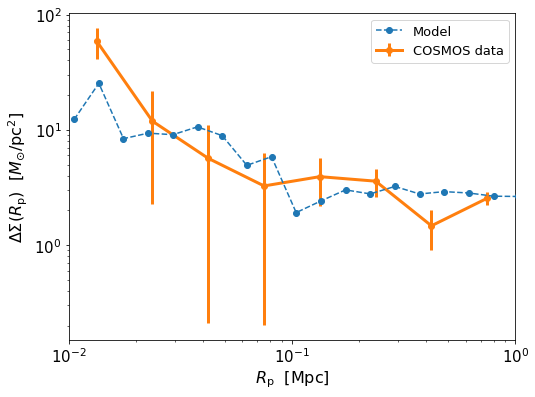

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


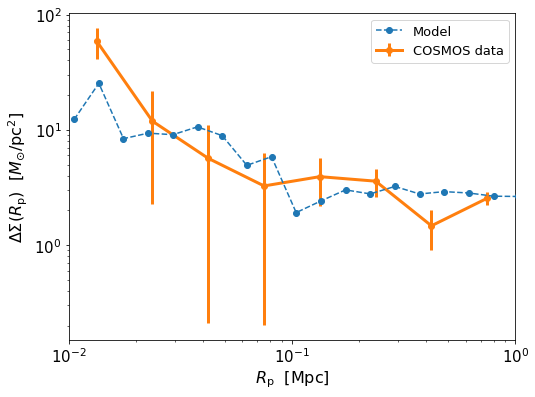

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


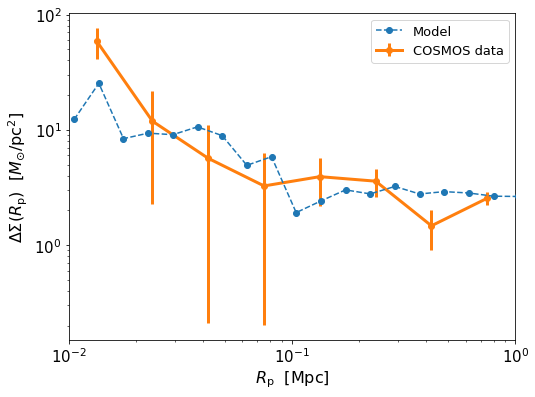

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


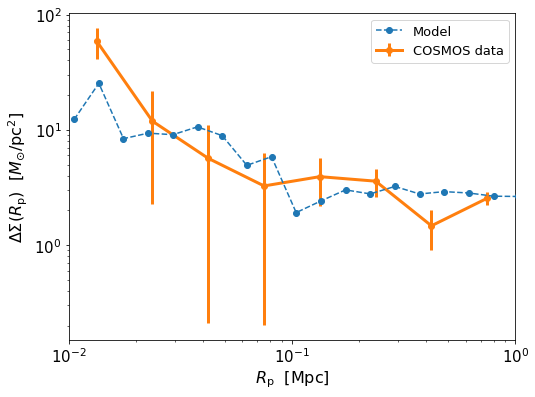

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


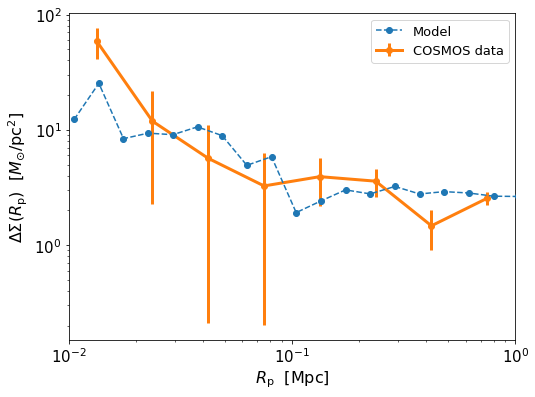

In [49]:
for i in range(5):
    # Predict DeltaSigma profiles
    wl_r, wl_ds = compute_deltaSigma_UM(UM_catalog, config, cosmos_data, sim_data)
    plot_deltaSigma(cosmos_data['cosmos_wl_table'], wl_r, wl_ds)
    np.savetxt('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/UM_dwarfs_WL_profile_{0}.txt'.format(str(i)),
               np.c_[wl_r,wl_ds], header = 'R DS')
    
    

they are all the same :|  ... Not sure how to easily add stochasticity

### DS for M*=8 and M*=9

In [4]:
def make_DS_catalog_given_params(params, run, config = None, cosmos_data = None, sim_data = None, write=False):

    if not config:
        config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
        config, cosmos_data, sim_data = initial_model(config)

    halo_data = sim_data['halocat'].halo_table
    
    stellar_masses = get_chris_stellar_masses(params, config, sim_data)
    halo_data['stellar_mass'] = 10**stellar_masses
    
#     halo_data_reduced = halo_data['stellar_mass','halo_mpeak','halo_mvir','halo_Vmax@Mpeak', 'halo_upid']
    halo_data_reduced = halo_data
    
    if write:
        halo_data_reduced.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_{0}.ascii'.format(run),
                  format ='ascii', overwrite=True, comment='#')
    
    return halo_data_reduced

In [5]:
best_UM_params = [ 0.31778976, 0.16864865, 2.76285812, 11.15042856,  0.12689323,  0.96288237, -0.03033116]

('cut galaxies table', 644849)
('cut galaxies table', 287813)


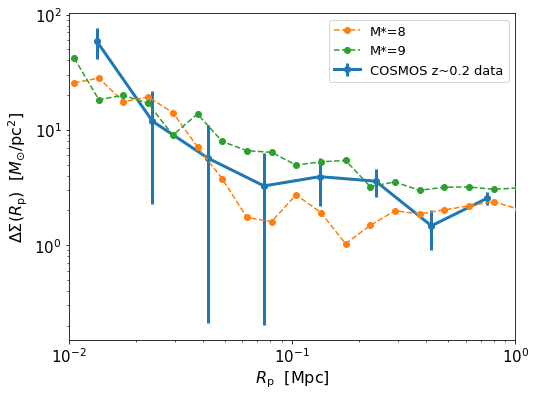

('cut galaxies table', 645716)
('cut galaxies table', 286949)


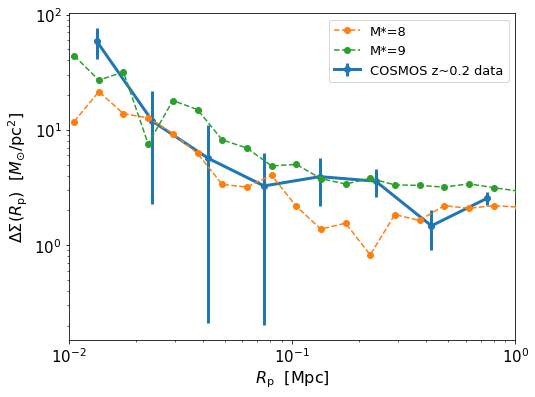

('cut galaxies table', 645756)
('cut galaxies table', 286593)


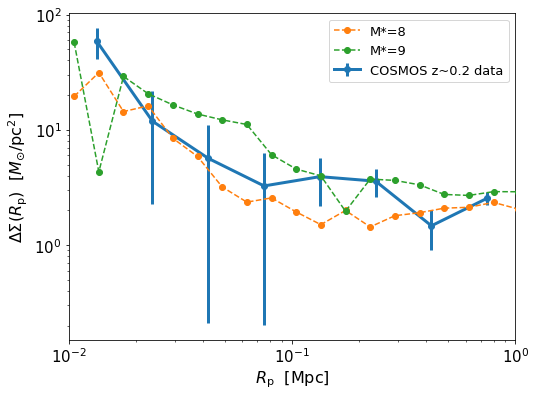

('cut galaxies table', 644606)
('cut galaxies table', 287053)


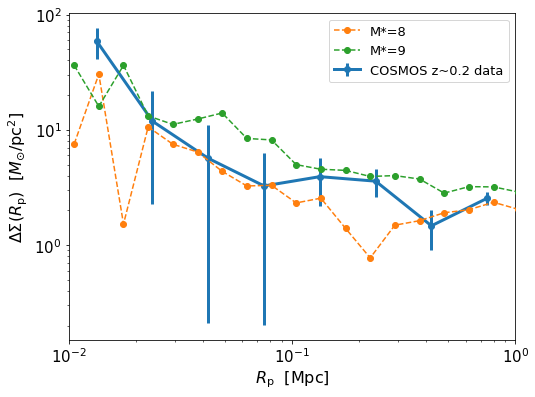

('cut galaxies table', 644906)
('cut galaxies table', 287553)


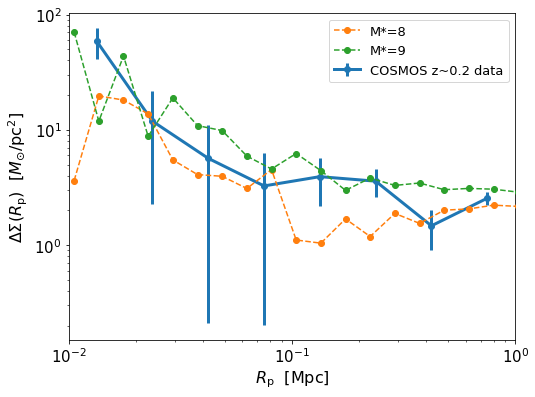

('cut galaxies table', 644917)
('cut galaxies table', 287215)


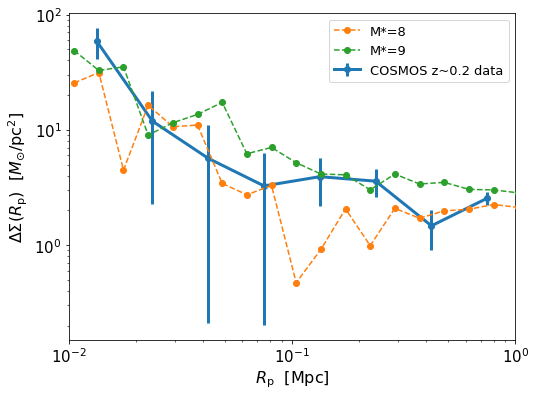

In [8]:
for i in [5,6,7,8,9,10]:
    # Predict DeltaSigma profiles
    catalog = make_DS_catalog_given_params(best_UM_params, 'UM_1',
                                    config = config, cosmos_data = cosmos_data, sim_data = sim_data,
                                    write=False)
    catalog = catalog[(np.log10(catalog['stellar_mass'])>7.8) & (np.log10(catalog['stellar_mass'])<9.2)]


    m_star8_catalog = catalog[(np.log10(catalog['stellar_mass'])>7.8) & (np.log10(catalog['stellar_mass'])<8.2)]
    m_star9_catalog = catalog[(np.log10(catalog['stellar_mass'])>8.8) & (np.log10(catalog['stellar_mass'])<9.2)]
    
    wl_r_8, wl_ds_8 = compute_deltaSigma_UM(m_star8_catalog, config, cosmos_data, sim_data)
    wl_r_9, wl_ds_9 = compute_deltaSigma_UM(m_star9_catalog, config, cosmos_data, sim_data)
    plot_deltaSigma(cosmos_data['cosmos_wl_table'], np.array([wl_r_8,wl_r_9]).T, np.array([wl_ds_8,wl_ds_9]).T,
                   labels=['M*=8', 'M*=9'])
    np.savetxt('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/notebooks/model_WL_profile/UM_dwarfs_WL_profiles_split_by_M*_{0}.txt'.format(str(i)),
               np.c_[wl_r_8,wl_ds_8, wl_ds_9], header = 'R DS_M*8 DS_M*9')
    
    

## SMFs

In [125]:
UM_smf_directory_obs= '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/UM/obs/'

UM_smf_files_obs = os.listdir(UM_smf_directory_obs)

UM_smfs_obs = [ascii.read(UM_smf_directory_obs + UM_smf_file) for UM_smf_file in UM_smf_files_obs]

In [127]:
#indices of smfs close to our 0.28
indices = [0, 4, 13]
UM_smf_files_obs = np.array(UM_smf_files_obs)[indices]
UM_smfs_obs = np.array(UM_smfs_obs)[indices]

In [140]:
UM_smf_directory_sim= '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/UM/sim/'

UM_smf_file_sim = os.listdir(UM_smf_directory_sim)[0]

UM_smfs_sim = ascii.read(UM_smf_directory_sim + UM_smf_file_sim) 

In [141]:
UM_smfs_sim

col1,col2,col3,col4,col5,col6,col7,col8,col9
float64,float64,float64,float64,float64,float64,float64,float64,float64
7.3,0.0717488,0.0135556,0.00796816,0.259604,0.00690722,0.00621036,7.2,7.4
7.5,0.0595812,0.0102892,0.00605058,0.272355,0.00644737,0.00440192,7.4,7.6
7.7,0.0486545,0.00680018,0.00452068,0.281714,0.0083423,0.00346643,7.6,7.8
7.9,0.0394811,0.00360163,0.00323065,0.299879,0.00519252,0.00544083,7.8,8.0
8.1,0.0324259,0.00145232,0.00249604,0.331815,0.00590616,0.0148292,8.0,8.2
8.3,0.0264492,0.000692455,0.00172631,0.362301,0.0117801,0.016914,8.2,8.4
8.5,0.0211117,0.000610853,0.00120541,0.377509,0.0108206,0.0170216,8.4,8.6
8.7,0.0167557,0.000412837,0.000953358,0.381614,0.00914389,0.0173011,8.6,8.8
8.9,0.0133429,0.000391506,0.000582479,0.382093,0.0087502,0.0191576,8.8,9.0


In [129]:
def plot_UM_SMF(UM_smf_table, UM_smf_file):
    
    dM = UM_smf_table['col2'][0] - UM_smf_table['col1'][0]
    
    mass_bins = UM_smf_table['col1']+ (dM/2.)
    
    label= UM_smf_file[:-4] +' (UM)'
    
    plt.errorbar(mass_bins, UM_smf_table['col3'], yerr=[UM_smf_table['col4'],UM_smf_table['col5']],
                 linewidth = 2, label = label )
    

    

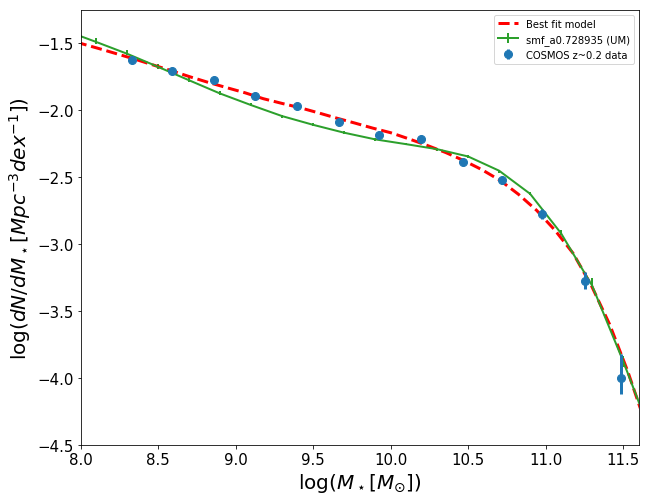

In [154]:
plt.figure(figsize=[10,8])

# for smf, file in zip(UM_smfs_obs,UM_smf_files_obs):
#     plot_UM_SMF(smf,file)
    
plt.errorbar(UM_smfs_sim['col1'], np.log10(UM_smfs_sim['col2']),
             yerr=[np.log10(UM_smfs_sim['col2']+UM_smfs_sim['col3'])-np.log10(UM_smfs_sim['col2']),
                   np.log10(UM_smfs_sim['col2']+UM_smfs_sim['col4'])-np.log10(UM_smfs_sim['col2'])],
                 linewidth = 2, label = UM_smf_file_sim[:-4]+' (UM)',
            color=new_colors[2])
    

# plot sim
plt.plot(sim_mass_centers, sim_logPhi, c='r', label='Best fit model',
         linewidth = 3, linestyle='--')

# plot COSMOS
# plt.plot(cosmos_data['cosmos_SMF_fit_table']['log_m'], cosmos_data['cosmos_SMF_fit_table']['log_phi'],
#          label='COSMOS z~0.2 fit', linewidth=3, zorder=0, color=new_colors[0])
# plt.fill_between(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi_inf'],
#                  cosmos_SMF_fit_table['log_phi_sup'], alpha=0.5)
plt.errorbar(cosmos_data['cosmos_SMF_points_table']['logM'], cosmos_data['cosmos_SMF_points_table']['Phi'],
             yerr=[cosmos_data['cosmos_SMF_points_table']['Phi_err+'],
             cosmos_data['cosmos_SMF_points_table']['Phi_err-']], fmt='o', elinewidth=3,
             markersize=8, c='#1f77b4', label='COSMOS z~0.2 data',
             zorder=3, color=new_colors[0])

#plot details
plt.xlabel(r'$\log(M_\star [M_{\odot}])$', fontsize=20)
plt.ylabel(r'$\log(dN/dM_\star [Mpc^{-3} dex^{-1}])$', fontsize=20)
plt.xlim([8,11.6])
plt.ylim([-4.5,-1.25])
plt.legend(loc='lower left', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend()
plt.show()



In [79]:
best_params = [ 0.53903687,  0.11330591,  2.72161542, 11.01133551,  0.11815845,  0.70730249,  0.28967114]
sim_mass_centers, sim_logPhi, wl_r, wl_ds = predict_model(best_params, config, cosmos_data, sim_data)

USING CHRIS' CODE with halo_Vmax@Mpeak
SMF computed
cut galaxies table 1561222
Ks_2sampResult(statistic=0.002045763040527504, pvalue=1.0000000000000002)
DS computed


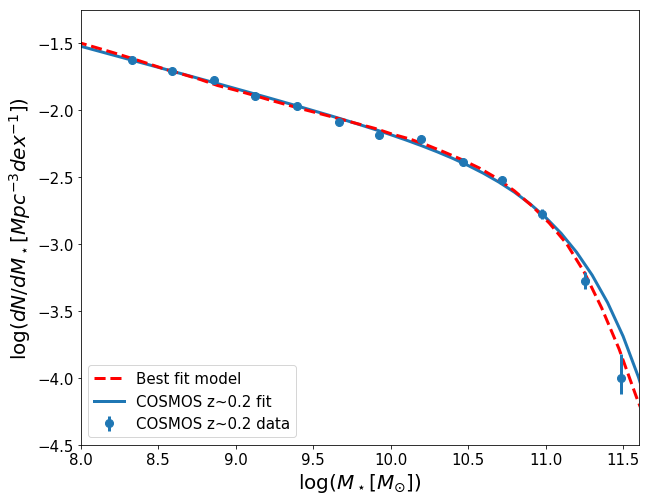

In [54]:
plot_SMF(smf_mass_bins, smf_log_phi, cosmos_data['cosmos_SMF_points_table'], cosmos_data['cosmos_SMF_fit_table'])

## Check priors 

In [157]:
UM_catalog


ID,DescID,UPID,Flags,Uparent_Dist,X,Y,Z,VX,VY,VZ,M,V,MP,VMP,R,Rank1,Rank2,RA,RARank,SM,ICL,SFR,obs_SM,obs_SFR,SSFR,SM/HM,obs_UV,stellar_mass
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2402494409,14114279,-1,2,2.0,15.11237,23.927719,39.993809,-101.650002,271.350006,-501.309998,98690000000000.0,682.359985,98690000000000.0,682.359985,898.609985,-0.191796,-0.944612,0.193902,0.006995,624200000000.0,185500000000.0,1.416,422900000000.0,0.8877,2.099e-12,0.006324,-18.478,11.6262376851469
117000000134642248,14114292,2402494409,8,0.280267,15.139074,23.706131,40.110489,3.06712,126.532379,-455.335754,1126000000.0,107.72628,40340000000.0,111.809998,20.232403,-0.168347,1.096783,0.355356,0.004981,5254000000.0,0.0,1.234,2799000000.0,0.703,2.512e-10,0.1303,-18.264,9.447002898466163
112000000220447759,14114305,2402494409,8,0.176275,15.21314,23.978075,39.88245,-390.766541,-116.732033,-296.937988,1031000000.0,85.856674,71320000000.0,118.209999,19.643745,-1.153136,1.50776,-0.080967,-1.321556,1668000000.0,0.0,0.001411,973800000.0,0.001118,1.148e-12,0.02338,-11.989,8.988469770209875
95000000587913536,14114348,2402494409,8,0.729134,14.620061,23.779465,40.399948,-115.190582,606.468506,-797.463684,14840000000.0,82.947815,132900000000.0,129.880005,47.781998,-1.40799,0.993044,0.141474,2.117998,14790000000.0,5602000.0,2.143,9873000000.0,5.984,6.06e-10,0.1113,-18.697,9.994449137014035
9000002264306060,14114412,2402494409,8,0.831355,15.032578,23.698879,40.70047,-153.646484,85.496735,1.4187,20340000000.0,62.033134,74750000000.0,86.099998,53.081776,-1.145341,0.823309,0.126857,-0.485957,248000000.0,11620000.0,0.1111,225400000.0,0.05377,2.385e-10,0.003317,-16.293,8.352953911710088
2402494410,14114279,2402494409,0,0.802979,14.73342,24.54076,39.958679,-285.0,948.179993,-628.169983,5697000000.0,33.59,16870000000.0,54.889999,34.73,-1.473392,2.143044,1.414695,-0.207874,19940000.0,0.0,0.008513,10020000.0,0.006396,6.384e-10,0.001182,0.0,7.000867721531227
2402494411,14114279,2402494409,0,0.281898,14.98934,24.08037,39.833401,762.840027,167.759995,411.970001,5241000000.0,30.110001,9116000000.0,32.0,33.778,0.053888,1.751088,-0.443672,0.176915,317900.0,0.0,0.0001543,274200.0,0.0004307,1.571e-09,3.487e-05,0.0,5.438067450453494
2402494412,14114279,2402494409,0,0.84827,14.85569,24.49477,39.553791,-118.650002,741.169983,-360.0,2963000000.0,20.66,7976000000.0,44.580002,27.927999,-2.17918,1.864711,0.386926,-0.697525,1929000.0,0.0,2.767e-06,855300.0,2.158e-06,2.524e-12,0.0002418,0.0,5.9321184720291225
2402494413,14114279,2402494409,0,0.742892,14.8217,24.481701,39.76086,-26.35,869.400024,-1179.97998,2507000000.0,25.049999,3874000000.0,36.619999,26.416,-1.473994,2.021893,2.2655,-0.079813,668200.0,0.0,0.0003317,507100.0,9.43e-05,1.859e-10,0.0001725,0.0,5.705093610547873


In [202]:
#plot SHMR for our params
params = best_params
x_field = 'VMP'
halo_data = {'VMP':np.logspace(1,3.2, 30)}
scatter_range = [2,3]

scatter_params = np.polyfit(scatter_range,[params[0],params[1]],1)
b_params = params[2:]

stellar_masses = get_sm_for_sim(halo_data, b_params, scatter_params, x_field)

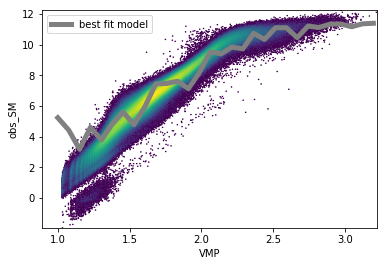

In [211]:
plt.hexbin(np.log10(UM_catalog['VMP']), np.log10(UM_catalog['obs_SM']), gridsize=500, bins='log', mincnt=1,
          label=None)
plt.plot(np.log10(halo_data['VMP']),stellar_masses, color='grey', linewidth=5, label='best fit model')
# plt.axvline(2.72, c='r')
# plt.axvline(2.5, linestyle='--')
# plt.axvline(3.5, linestyle='--')
plt.xlabel('VMP')
plt.ylabel('obs_SM')
plt.legend()
plt.show()

# convert x and y and save as ascii file in order to add to halo tools cache


In [216]:
UM_catalog['X'] = UM_catalog['X'] % config['sim_lbox']
UM_catalog['Y'] = UM_catalog['Y'] % config['sim_lbox']
UM_catalog['Z'] = UM_catalog['Z'] % config['sim_lbox']

In [220]:
UM_catalog.remove_column('stellar_mass')

In [221]:
UM_catalog

ID,DescID,UPID,Flags,Uparent_Dist,X,Y,Z,VX,VY,VZ,M,V,MP,VMP,R,Rank1,Rank2,RA,RARank,SM,ICL,SFR,obs_SM,obs_SFR,SSFR,SM/HM,obs_UV
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2402494409,14114279,-1,2,2.0,15.11237,23.927719,39.993809,-101.650002,271.350006,-501.309998,98690000000000.0,682.359985,98690000000000.0,682.359985,898.609985,-0.191796,-0.944612,0.193902,0.006995,624200000000.0,185500000000.0,1.416,422900000000.0,0.8877,2.099e-12,0.006324,-18.478
117000000134642248,14114292,2402494409,8,0.280267,15.139074,23.706131,40.110489,3.06712,126.532379,-455.335754,1126000000.0,107.72628,40340000000.0,111.809998,20.232403,-0.168347,1.096783,0.355356,0.004981,5254000000.0,0.0,1.234,2799000000.0,0.703,2.512e-10,0.1303,-18.264
112000000220447759,14114305,2402494409,8,0.176275,15.21314,23.978075,39.88245,-390.766541,-116.732033,-296.937988,1031000000.0,85.856674,71320000000.0,118.209999,19.643745,-1.153136,1.50776,-0.080967,-1.321556,1668000000.0,0.0,0.001411,973800000.0,0.001118,1.148e-12,0.02338,-11.989
95000000587913536,14114348,2402494409,8,0.729134,14.620061,23.779465,40.399948,-115.190582,606.468506,-797.463684,14840000000.0,82.947815,132900000000.0,129.880005,47.781998,-1.40799,0.993044,0.141474,2.117998,14790000000.0,5602000.0,2.143,9873000000.0,5.984,6.06e-10,0.1113,-18.697
9000002264306060,14114412,2402494409,8,0.831355,15.032578,23.698879,40.70047,-153.646484,85.496735,1.4187,20340000000.0,62.033134,74750000000.0,86.099998,53.081776,-1.145341,0.823309,0.126857,-0.485957,248000000.0,11620000.0,0.1111,225400000.0,0.05377,2.385e-10,0.003317,-16.293
2402494410,14114279,2402494409,0,0.802979,14.73342,24.54076,39.958679,-285.0,948.179993,-628.169983,5697000000.0,33.59,16870000000.0,54.889999,34.73,-1.473392,2.143044,1.414695,-0.207874,19940000.0,0.0,0.008513,10020000.0,0.006396,6.384e-10,0.001182,0.0
2402494411,14114279,2402494409,0,0.281898,14.98934,24.08037,39.833401,762.840027,167.759995,411.970001,5241000000.0,30.110001,9116000000.0,32.0,33.778,0.053888,1.751088,-0.443672,0.176915,317900.0,0.0,0.0001543,274200.0,0.0004307,1.571e-09,3.487e-05,0.0
2402494412,14114279,2402494409,0,0.84827,14.85569,24.49477,39.553791,-118.650002,741.169983,-360.0,2963000000.0,20.66,7976000000.0,44.580002,27.927999,-2.17918,1.864711,0.386926,-0.697525,1929000.0,0.0,2.767e-06,855300.0,2.158e-06,2.524e-12,0.0002418,0.0
2402494413,14114279,2402494409,0,0.742892,14.8217,24.481701,39.76086,-26.35,869.400024,-1179.97998,2507000000.0,25.049999,3874000000.0,36.619999,26.416,-1.473994,2.021893,2.2655,-0.079813,668200.0,0.0,0.0003317,507100.0,9.43e-05,1.859e-10,0.0001725,0.0


In [223]:
ascii.write(UM_catalog, UM_catalog_location+'sfr_catalog_0.782092_proper_bounds.txt')